In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

In [3]:
dataset=r'dataset'
imagePaths=list(paths.list_images(dataset))

In [4]:
print(f"We have {len(imagePaths)} in our Dataset")

We have 3833 in our Dataset


In [5]:
image_height = 224
image_width = 224
image_channels = 3

In [6]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(image_height, image_width))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [7]:
print(f"Image is {data[0].shape[0]}x{data[0].shape[1]} Pixels and Image Channel is {data[0].shape[2]}")

Image is 224x224 Pixels and Image Channel is 3


In [8]:
data = np.array(data)
labels = np.array(labels)

In [9]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [10]:
labels.shape

(3833, 2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [12]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))


In [13]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_14_add (Add)             (None, 7, 7, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_expand (Conv2D)       (None, 7, 7, 960)    153600      ['block_14_add[0][0]']           
                                                                                                  
 block_15_expand_BN (BatchNorma  (None, 7, 7, 960)   3840        ['block_15_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_15_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_15_expand_BN[0][0]']     
                                                                                                  
 block_15_

In [14]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [15]:
for layer in baseModel.layers:
    layer.trainable=False

In [16]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
CNN_model_checkpoint = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)

In [22]:
learning_rate=0.001
epochs=1000
BS=25

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=learning_rate,decay=learning_rate/epochs)
              ,metrics=['acc'])

H=model.fit(
    aug.flow(X_train,y_train,batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    callbacks=[early_stopping, CNN_model_checkpoint],
    epochs=epochs  
)

Epoch 1/1000
122/122 [==============================] - 137s 1s/step - loss: 0.2070 - acc: 0.9247 - val_loss: 0.0728 - val_acc: 0.9765
Epoch 2/1000
122/122 [==============================] - 134s 1s/step - loss: 0.0883 - acc: 0.9671 - val_loss: 0.0450 - val_acc: 0.9831
Epoch 3/1000
122/122 [==============================] - 139s 1s/step - loss: 0.0816 - acc: 0.9724 - val_loss: 0.0531 - val_acc: 0.9844
Epoch 4/1000
122/122 [==============================] - 134s 1s/step - loss: 0.0736 - acc: 0.9734 - val_loss: 0.0530 - val_acc: 0.9844
Epoch 5/1000
122/122 [==============================] - 134s 1s/step - loss: 0.0543 - acc: 0.9819 - val_loss: 0.0375 - val_acc: 0.9857
Epoch 6/1000
122/122 [==============================] - 83s 675ms/step - loss: 0.0578 - acc: 0.9793 - val_loss: 0.0508 - val_acc: 0.9831
Epoch 7/1000
122/122 [==============================] - 58s 471ms/step - loss: 0.0538 - acc: 0.9819 - val_loss: 0.0658 - val_acc: 0.9778
Epoch 8/1000
122/122 [=============================

In [23]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 8s 340ms/step - loss: 0.0195 - acc: 0.9948


[0.01945250853896141, 0.9947848916053772]

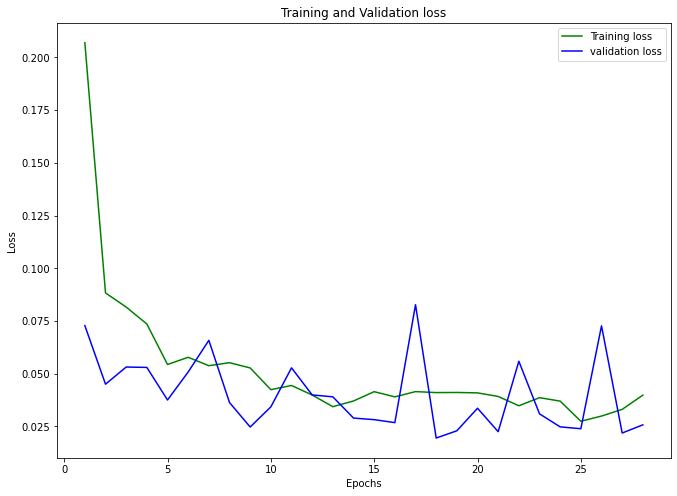

In [28]:
plt.figure(figsize=(11,8))
loss_train = H.history['loss']
loss_val = H.history['val_loss']
epochs = range(1,len(loss_train) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

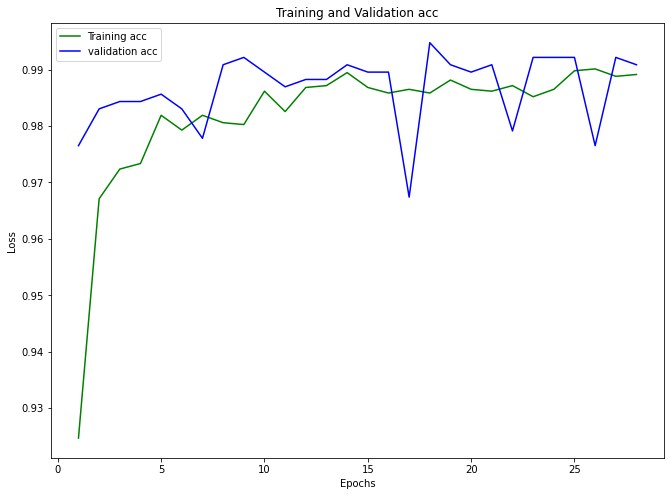

In [27]:
plt.figure(figsize=(11,8))
val_train = H.history['acc']
val_acc = H.history['val_acc']
epochs = range(1,len(val_acc)+1)
plt.plot(epochs, val_train, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()